In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from simsopt.geo import SurfaceRZFourier
from collections import defaultdict

CycleGAN_dir = "/Users/rogeriojorge/local/CycleGAN"
df = pd.read_csv(os.path.join(CycleGAN_dir,"stel_results.csv"))
df = df.drop_duplicates()
# df.to_csv(os.path.join(CycleGAN_dir, "stel_results.csv"), index=False)

In [13]:
print(f"Number of repeated rows: {df.duplicated().sum()}, Total number of rows: {len(df)}")
print(f"Number of rows with 'qi' equal to nan: {df['qi_global'].isna().sum()}")
print(f"Fraction of stellarators with no losses at 1x10^(-2)s: {100-len(df[df['loss_fraction_1e-2s']>0]['loss_fraction_1e-2s'])/len(df)*100:.2f}%")

Number of repeated rows: 0, Total number of rows: 36220
Number of rows with 'qi' equal to nan: 8
Fraction of stellarators with no losses at 1x10^(-2)s: 2.39%


Text(0.5, 0.98, 'Cross-sections of the surface with max_elongation=1.31e+00, iota=0.53, aspect ratio=9.6 and nfp=8\nfile=heliotron_randomAspect_finiteBeta_maxm1_maxn1_LMN8_000681')

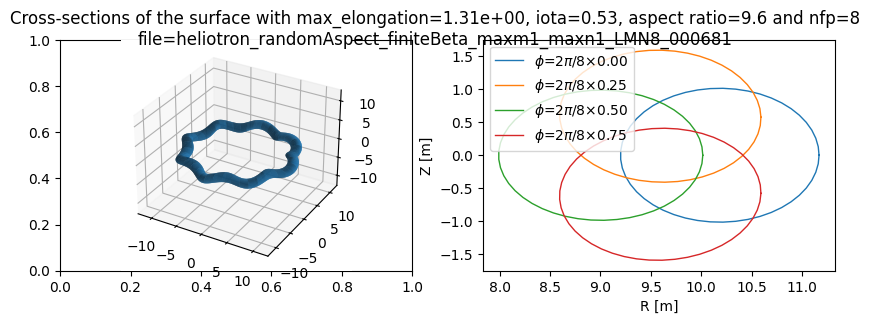

In [14]:
quantity = 'max_elongation'#'qi_global'#'well'#'fixed_grad_Q_avgs_divided_by_FSA_grad_x'#qi, qa, qp, qh, aspect_ratio
row = df[quantity].idxmin()
# row = df[quantity].idxmax()
# print(f"The ID with the value of {quantity} of {df[quantity].iloc[row]} is: {row}")
# print(df['file'].iloc[row])
row_data = df.iloc[row]

quadpoints_theta = np.linspace(0, 1, 50, endpoint=True)
quadpoints_phi = np.linspace(0, 1, 40*int(row_data['nfp']), endpoint=True)
surf = SurfaceRZFourier(nfp=int(row_data['nfp']),mpol=4,ntor=4,quadpoints_phi=quadpoints_phi,quadpoints_theta=quadpoints_theta)
mode_names = [f"rbc_{m}_{n}" for m in range(0, 5) for n in range(-4, 5)] + \
             [f"zbs_{m}_{n}" for m in range(0, 5) for n in range(-4, 5)]
mode_names = [name for name in mode_names if name in df.columns]
surf_x = row_data[mode_names].values.astype(float)
surf.x = surf_x

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
# axs[0].axis('off')
surf.plot(ax=axs[0], show=False)
for phi in np.linspace(0,2*np.pi/int(row_data['nfp']), 4, endpoint=False):
    cross_section = surf.cross_section(phi=phi)
    axs[1].plot(np.sqrt(cross_section[:, 0] ** 2 + cross_section[:, 1] ** 2), cross_section[:, 2], linewidth=1, label=rf"$\phi$=2$\pi$/{int(row_data['nfp'])}$\times${phi/2/np.pi*row_data['nfp']:.2f}")
axs[1].set_xlabel("R [m]")
axs[1].set_ylabel("Z [m]")
axs[1].legend()
fig.suptitle((f"Cross-sections of the surface with {quantity}={df[quantity].iloc[row]:.2e}, iota={row_data['mean_iota']:.2f}, aspect ratio={row_data['aspect_ratio']:.1f} and nfp={int(row_data['nfp'])}\n"
          +f"file={row_data['file']}"))

In [20]:
## XYZ Points on the surface of the stellarator
# x, y, z = surf.gamma().transpose(2, 0, 1)

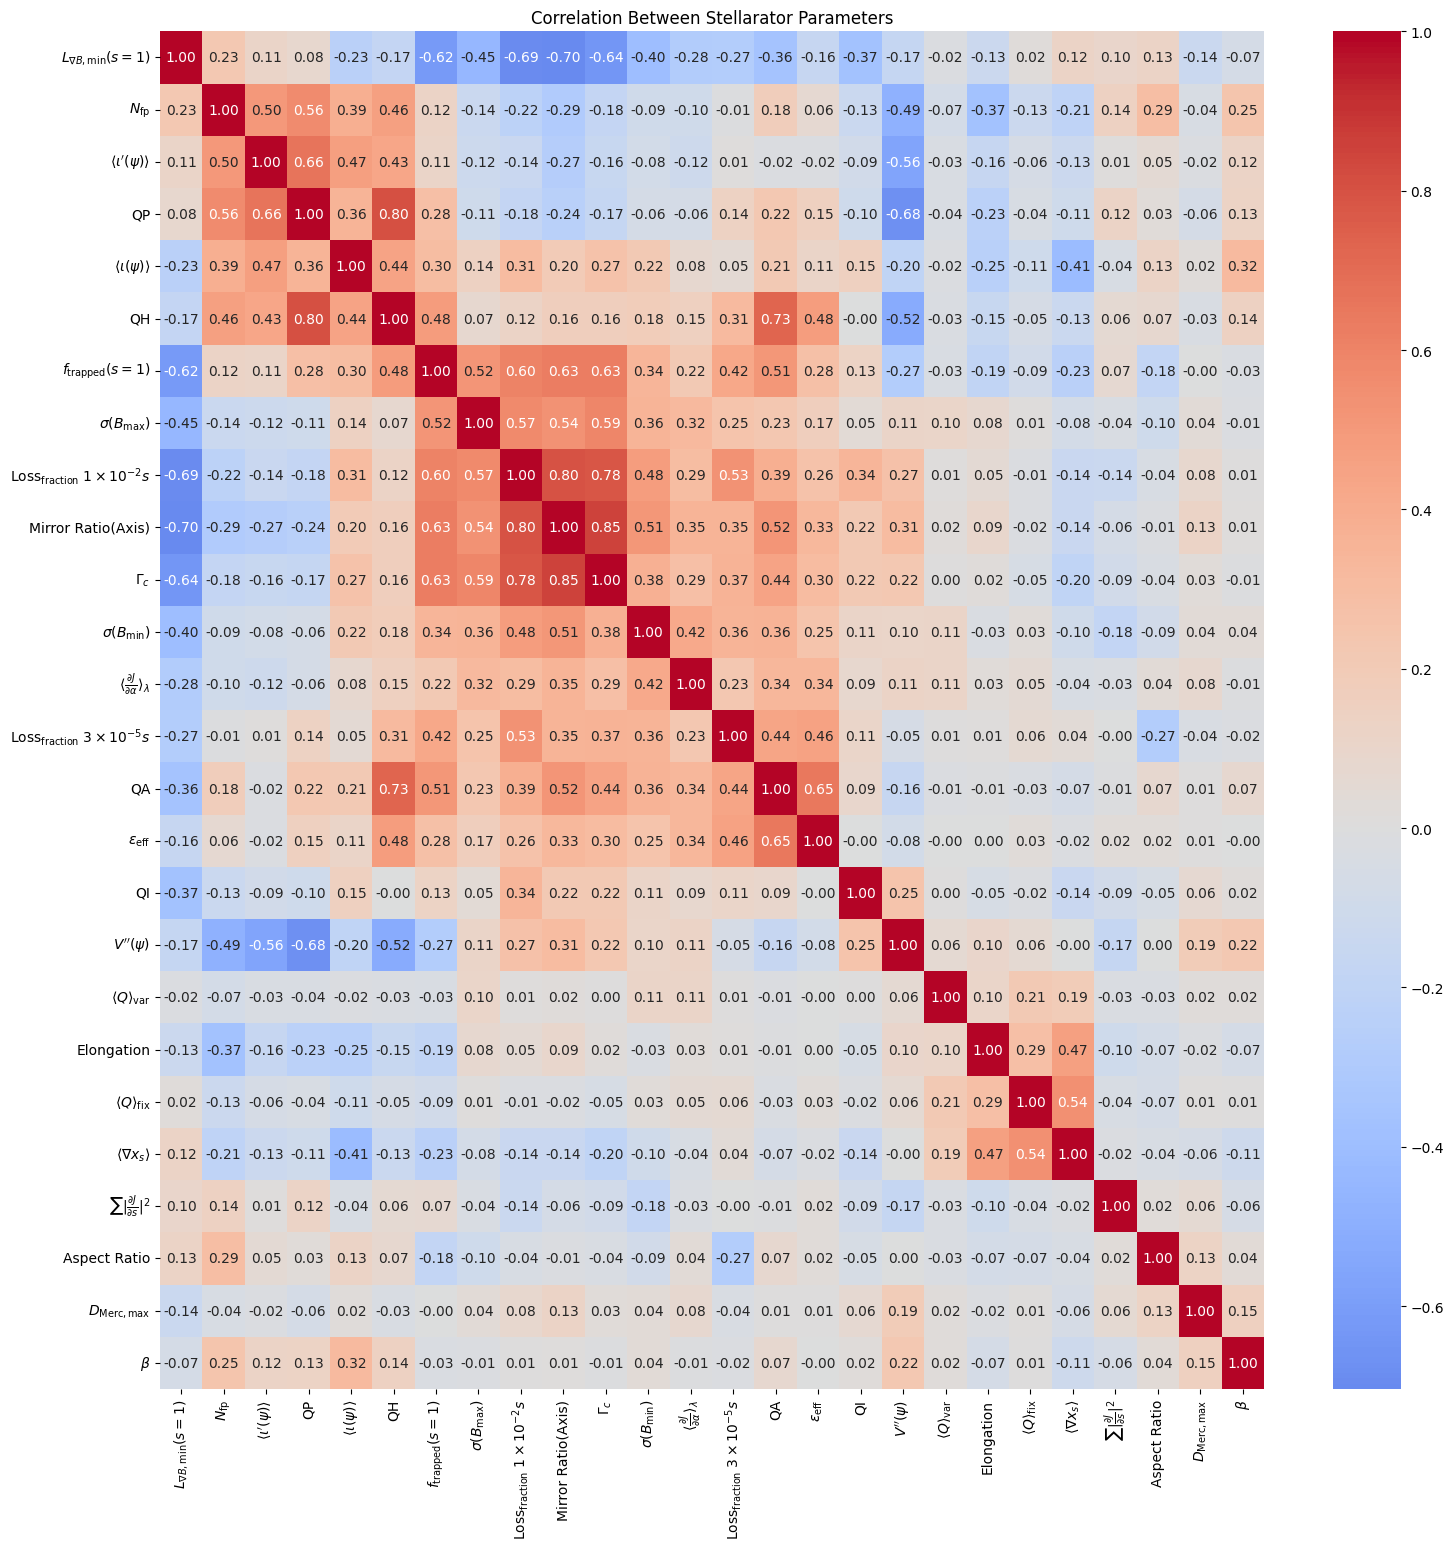

In [16]:

# Step 1: Identify relevant columns
cols = ["mean_shear", "mean_iota", "qa_global", "qi_global", "qp_global", "qh_global", "magnetic_well_global","L_grad_B_min_surface",
        "max_elongation","varied_grad_Q_avgs","fixed_grad_Q_avgs","DMerc_max","FSA_grad_xs",
        "nfp","mirror_ratio_axis","aspect_ratio",
        # "mirror_ratio_axis","loss_fraction_5e-3s","loss_fraction_1e-4s",
        "betatotal","loss_fraction_1e-2s","loss_fraction_3e-5s",
        "gamma_c_global","effective_ripple_global","trapped_fraction_surface",
        "B_max_std_this_rho","B_min_std_this_rho",
        "dJ_ds_sum_this_rho",
        # "dJ_dalpha_sum_this_rho",
        "dJ_dalpha_DESC_metric_this_rho"
        ]

# Optional: Custom display names
col_display_names = {
    "mean_shear": r"$\langle\iota'(\psi)\rangle$",
    "mean_iota": r"$\langle\iota(\psi)\rangle$",
    "qa_global": r"QA",
    "qi_global": r"QI",
    "qp_global": r"QP",
    "qh_global": r"QH",
    "magnetic_well_global": r"$V''(\psi)$",
    "L_grad_B_min_surface": r"$L_{\nabla B,\mathrm{min}}(s=1)$",
    "L_grad_B_max_surface": r"$L_{\nabla B,\mathrm{max}}(s=1)$",
    "max_elongation": "Elongation",
    "varied_grad_Q_avgs": r"$\langle Q \rangle_{\mathrm{var}}$",
    "fixed_grad_Q_avgs": r"$\langle Q \rangle_{\mathrm{fix}}$",
    "DMerc_min": r"$D_{\mathrm{Merc,min}}$",
    "DMerc_max": r"$D_{\mathrm{Merc,max}}$",
    "FSA_grad_xs": r"$\langle \nabla x_s \rangle$",
    "nfp": r"$N_{\mathrm{fp}}$",
    "mirror_ratio_axis": "Mirror Ratio(Axis)",
    "mirror_ratio_surface": "Mirror Ratio($s=1$)",
    "aspect_ratio": "Aspect Ratio",
    "loss_fraction_5e-3s": r"$\mathrm{Loss}_{\mathrm{fraction}}$ $5\times10^{-3}s$",
    "loss_fraction_1e-4s": r"$\mathrm{Loss}_{\mathrm{fraction}}$ $1\times10^{-4}s$",
    "loss_fraction_3e-5s": r"$\mathrm{Loss}_{\mathrm{fraction}}$ $3\times10^{-5}s$",
    "loss_fraction_1e-2s": r"$\mathrm{Loss}_{\mathrm{fraction}}$ $1\times10^{-2}s$",
    "betatotal": r"$\beta$",
    "gamma_c_global": r"$\Gamma_c$",
    "effective_ripple_global": r"$\epsilon_{\mathrm{eff}}$",
    "trapped_fraction_surface": r"$f_{\mathrm{trapped}}(s=1)$",
    "trapped_fraction_axis": r"$f_{\mathrm{trapped}}(s=0)$",
    "B_max_std_this_rho": r"$\sigma(B_{\mathrm{max}})$",
    "B_min_std_this_rho": r"$\sigma(B_{\mathrm{min}})$",
    "dJ_ds_sum_this_rho": r"$\sum |\frac{\partial J}{\partial s}|^2$",
    "dJ_dalpha_sum_this_rho": r"$\sum |\langle \frac{\partial J}{\partial \alpha}|^2$",
    "dJ_dalpha_DESC_metric_this_rho": r"$\langle \frac{\partial J}{\partial \alpha} \rangle_{\lambda}$"
}

# Step 2: Subset the DataFrame
sub_df = df[cols].copy()

# Step 3: Drop any rows with NaNs (optional but recommended)
sub_df = sub_df.dropna()

# Step 4: Compute the correlation matrix
corr = sub_df.corr()

# Step 5: Cluster ordering
linkage = sch.linkage(corr, method='average')
dendro = sch.dendrogram(linkage, no_plot=True)
ordered_cols = [corr.columns[i] for i in dendro['leaves']]

# Step 6: Apply custom names
renamed_corr = corr.loc[ordered_cols, ordered_cols].copy()
renamed_corr.index = [col_display_names[col] for col in ordered_cols]
renamed_corr.columns = [col_display_names[col] for col in ordered_cols]

# Step 7: Plot heatmap
plt.figure(figsize=(len(ordered_cols)*0.6, len(ordered_cols)*0.6))
sns.heatmap(renamed_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between Stellarator Parameters")
plt.tight_layout()
plt.savefig(os.path.join(CycleGAN_dir, "correlation_matrix.png"), dpi=100)

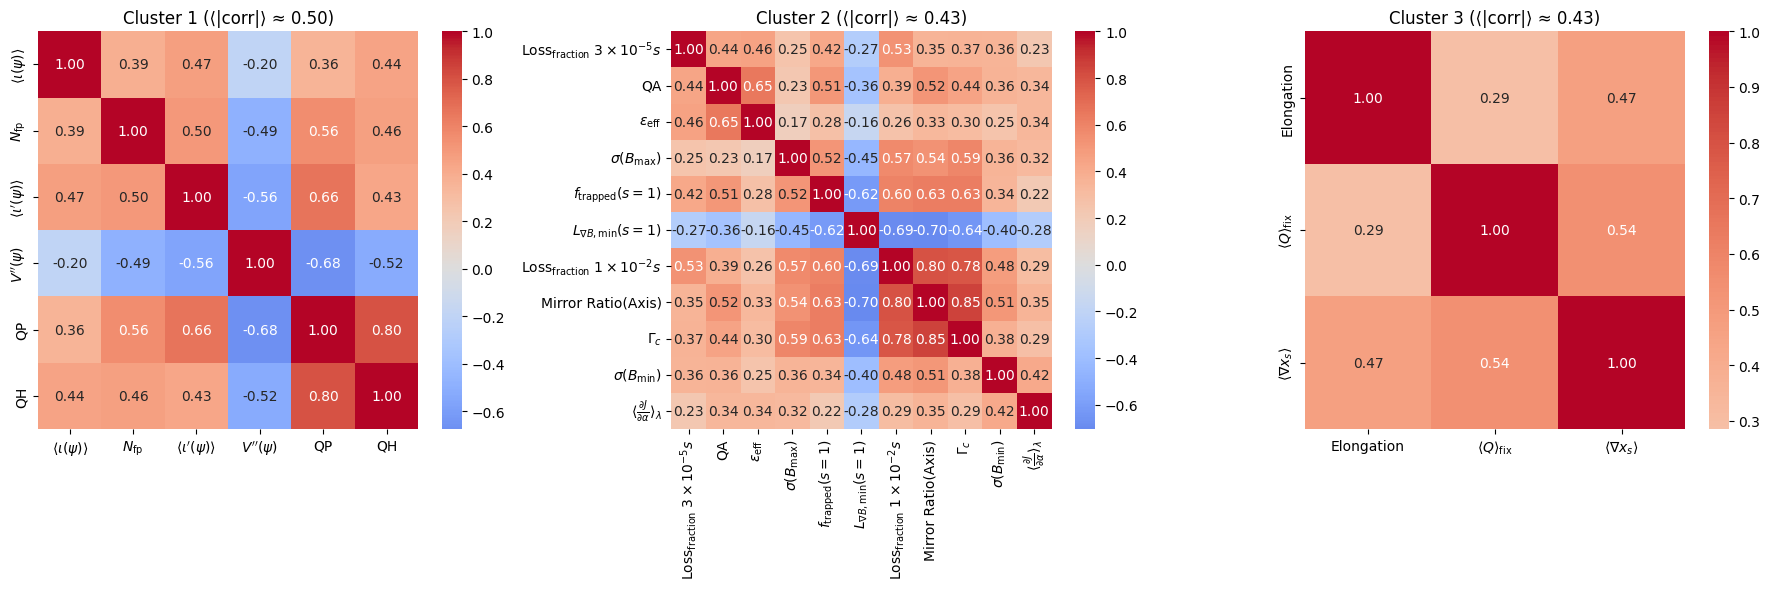

In [17]:
def plot_correlation_clusters(df, cols, col_display_names=None, t=0.8, min_cluster_size=2, figsize=6, n_cols=2):
    sub_df = df[cols].dropna()
    corr = sub_df.corr()
    dist = 1 - np.abs(corr.values)
    Z = sch.linkage(squareform(dist), method='average')
    cluster_ids = sch.fcluster(Z, t=t, criterion='distance')

    clusters = defaultdict(list)
    for col, cid in zip(corr.columns, cluster_ids):
        clusters[cid].append(col)
    groups = [g for g in clusters.values() if len(g) >= min_cluster_size]

    n_rows = int(np.ceil(len(groups) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*figsize, n_rows*figsize))
    axes = np.ravel(axes)

    for i, group in enumerate(groups):
        sub_corr = corr.loc[group, group]
        order = sch.dendrogram(sch.linkage(squareform(1 - np.abs(sub_corr)), method='average'), no_plot=True)['leaves']
        ordered = [sub_corr.columns[j] for j in order]
        sub_corr = sub_corr.loc[ordered, ordered]

        labels = [col_display_names.get(c, c) if col_display_names else c for c in ordered]
        sub_corr.index = labels
        sub_corr.columns = labels

        sns.heatmap(sub_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[i])
        avg = np.mean(np.abs(np.triu(sub_corr.values, k=1)[np.triu_indices(len(labels), k=1)]))
        axes[i].set_title(f"Cluster {i+1} (⟨|corr|⟩ ≈ {avg:.2f})")

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    
    
plot_correlation_clusters(df, cols, col_display_names, t=0.75, n_cols=3)
plt.tight_layout()
plt.savefig(os.path.join(CycleGAN_dir, "correlation_matrix_clusters.png"), dpi=100)